In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [21]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

Age_at_Exam    sBP   sBP_Date        BMI   BMI_Date   LDL   LDL_Date   HDL  \
0           65  126.0 2013-06-11  31.000000 2013-06-11  1.66 2013-06-14  1.11   
1           62  135.0 2014-06-19  25.846483 2014-10-17  2.49 2014-05-28  1.37   
2           63  133.0 2012-07-31  30.900000 2011-12-01  1.65 2012-06-01   NaN   
3           51  136.0 2014-01-06  56.710775 2014-01-06  2.80 2014-01-14  1.94   
4           40  123.0 2015-06-12  33.067867 2015-06-12  2.48 2015-06-24  1.17   

    HDL_Date  A1c  ... leastO(A1c_Date)  leastO(DM_OnsetDate)  \
0 2013-06-14  5.4  ...              NaN                   NaN   
1 2014-05-28  5.8  ...              NaN                   NaN   
2        NaT  6.1  ...              NaN                   NaN   
3 2014-01-14  6.0  ...              NaN                   NaN   
4 2015-06-24  5.8  ...              NaN                   NaN   

  leastO(FBS_Date)  LeastOfAll A1C_BEF_DM  FBS_BEF_DM        Patient_ID  \
0              NaN         NaN        NaN         NaN  4001000000255903   
1              NaN         NaN        NaN         NaN  4001000000256456   
2              NaN         NaN        NaN         NaN  1001000000000054   
3              NaN         NaN        NaN         NaN  4001000000259496   
4              NaN         NaN        NaN         NaN  4001000000262094   

  DM_Onset_Revised  DM_Onset_Revised_1YrPrior DIABETES  
0              NaT                        NaT       No  
1              NaT                        NaT       No  
2              NaT                        NaT       No  
3              NaT                        NaT       No  
4              NaT                        NaT       No  

[5 rows x 43 columns]

In [6]:
print(data.shape)

(10000, 43)


In [7]:
# Count the number of missing values (NaN or None) in each column of the 'data' DataFrame
missing_value_counts = data.isnull().sum()
missing_value_counts

Age_at_Exam                                   0
sBP                                           4
sBP_Date                                      0
BMI                                           0
BMI_Date                                      0
LDL                                          61
LDL_Date                                      0
HDL                                          72
HDL_Date                                     64
A1c                                           0
A1c_Date                                      0
TG                                           53
TG_Date                                      42
FBS                                           0
FBS_Date                                      0
FBS>DM                                        0
Total_Cholesterol                           207
Total_Cholesterol_Lab_Date                  197
Diabetes                                      0
DM_OnsetDate                               4863
Depression                              

In [18]:
# Check how many patients there are
data['Patient_ID'].unique().shape

(8602,)

In [23]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)

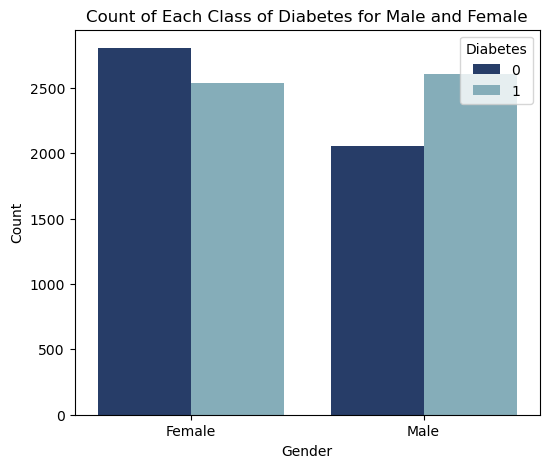

In [24]:
# Define a list of colors
colors = ['#1c3a73', '#7cb1c2']

# Create the grouped bar chart using seaborn's countplot function with specified colors
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='Sex', hue='DIABETES', palette=colors)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Each Class of Diabetes for Male and Female')
plt.legend(title='Diabetes')
plt.show()

In [25]:
print('Oldest individual in the dataset was of:', data['Age_at_Exam'].max(), 'Years')
print('Youngest individual in the dataset was of:', data['Age_at_Exam'].min(), 'Years')
print('Average age in the dataset:', data['Age_at_Exam'].mean(), 'Years')

Oldest individual in the dataset was of: 90 Years
Youngest individual in the dataset was of: 18 Years
Average age in the dataset: 63.1976 Years


In [ ]:
x = data[-'diabetes']
y = data['diabetes']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Define a function to run k-fold cross-validation for linear regression
def run_kfold_regression(data_x, data_y, k):
    mean_train_loss = 0
    mean_validation_loss = 0

    kfold = KFold(n_splits=k, shuffle=True)
    for train_indexes, validation_indexes in kfold.split(data_x):
        k_fold_train_x = data_x[train_indexes]
        k_fold_train_y = data_y[train_indexes]
        validation_x = data_x[validation_indexes]
        validation_y = data_y[validation_indexes]

        model = LinearRegression()
        model.fit(k_fold_train_x, k_fold_train_y)

        train_y_hat = model.predict(k_fold_train_x)
        train_mse = mean_squared_error(k_fold_train_y, train_y_hat)
        mean_train_loss += train_mse

        validation_y_hat = model.predict(validation_x)
        validation_mse = mean_squared_error(validation_y, validation_y_hat)
        mean_validation_loss += validation_mse

    mean_train_loss /= k
    mean_validation_loss /= k

    return mean_train_loss, mean_validation_loss

# Initialize lists to store model complexity, train loss, and validation loss
model_complexity_list = []
train_loss_list = []
validation_loss_list = []

# Loop over different model complexities
for model_complexity in range(1, 20):
    data_x = np.hstack([X_train**i for i in range(1, model_complexity+1)])
    data_y = y_train

    # Run k-fold cross-validation and compute train and validation losses
    train_loss, validation_loss = run_kfold_regression(data_x, data_y, 20)

    model_complexity_list.append(model_complexity)
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)